# Smell of Gas Prediction (Job Type SF5)

In this notebook, we predict how often a smell of gas call will be reported from the Public. The Call Centre will be able to take corrective actions in advance to improve resource allocation and corrective maintenance efficiency.

We are going to use the dataset **Corrective Maintenance and Weather Dataset** 

Summary:
 - [Data Pre-processing](#preprocess)
     - [Load Data](#load_data)
     - [Prepare Data](#prep_data)
     - [Visualise Data](#viz_data)
     - [Normalise Data](#normalise)
 - [Build the Models](#models)
     - [Split Data into Train and Test Sets](#split)
     - [Gated Recurrent Unit (GRU)](#gru)
     - [Long-short Term Memory (LSTM)](#lstm)
 - [Compare Models' Performance](#compare)
 - [Use Model for Prediction](#apply)
  
__All the libraries used in this notebook are <font color='red'>Open Source</font>__.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from utils import *

# the following to lines will tell to the python kernel to alway update the kernel for every utils.py
# modification, without the need of restarting the kernel.
# Of course, for every motification in util.py, we need to reload this cell
%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


<a id='preprocess'></a>
## Data Pre-processing

<a id='load_data'></a>
### Load Data

In [2]:
# Load data
df_raw = pd.read_csv('../data/corrective_maint_job_types.csv',index_col=0, decimal=".")
df_raw.head()

,notif_date,floc,order,job_type,catalog_profile,meter_install_date,meter_model,network,postcode,suburb,...,distance,evapo_trans_0000_2400,rain_0900_0900,pan_evap_0900_0900,max_temp,min_temp,max_rel_humidity,min_rel_humidity,avg_10m_wind_speed,solar_radiation
notif,,,,,,,,,,,,,,,,,,,,,
300713965.0,2011-12-21,504107.0,NaN,SPH,MAIN,NaN,NaN,SM,6110.0,SOUTHERN RIVER,...,0.131159,7.3,0.0,10.8,28.9,13.6,97.0,32.0,3.87,34.47
300719006.0,2011-12-21,673096.0,NaN,SPL,MAIN,NaN,NaN,SM,6111.0,KELMSCOTT,...,0.099496,7.9,0.0,8.0,30.6,16.4,82.0,35.0,4.24,34.47
300719010.0,2011-12-21,810841.0,NaN,SPH,MAIN,NaN,NaN,NM,6019.0,WEMBLEY DOWNS,...,0.049014,6.4,0.0,36.8,25.8,16.9,91.0,61.0,4.63,34.24
300719430.0,2011-12-21,27.0,NaN,SPH,MAIN,NaN,NaN,NM,6026.0,WOODVALE,...,0.138307,7.2,0.0,2.4,29.2,17.4,89.0,38.0,3.37,34.38
300730505.0,2011-12-21,117547.0,NaN,SF1,DOMMETER,14.01.2014,M8A,SM,6153.0,NaN,...,0.087419,7.3,0.0,10.8,28.9,13.6,97.0,32.0,3.87,34.47


<a id='prep_data'></a>
### Prepare Data

In [3]:
# Prepare data for analysis
df_analysis = pd.DataFrame()
df_wide = pd.DataFrame()

# Fields to directly copy to new analysis dataframe
make_copy = (
    ('notif_date', 'date'),
    ('job_type', 'job_type'),
    ('network', 'network'),
    ('evapo_trans_0000_2400', 'evapo_trans_0000_2400'),
    ('rain_0900_0900', 'rain_0900_0900'),
    ('pan_evap_0900_0900', 'pan_evap_0900_0900'),
    ('max_temp', 'max_temp'),
    ('min_temp', 'min_temp'),
    ('max_rel_humidity', 'max_rel_humidity'),
    ('min_rel_humidity', 'min_rel_humidity'),
    ('avg_10m_wind_speed', 'avg_10m_wind_speed'),
    ('solar_radiation', 'solar_radiation')
)
for orig, new in make_copy:
    df_analysis[new] = df_raw[orig]

# Convert categorical columns to binary
#job = pd.get_dummies(df_analysis['job_type'])
#df_analysis = df_analysis.drop('job_type', axis=1)
#df_analysis = df_analysis.join(job)
net = pd.get_dummies(df_analysis['network'])
#df_analysis = df_analysis.drop('network', axis=1)
df_analysis = df_analysis.join(net)

# Set date for timeseries index
#df_analysis=df_analysis.set_index('date')
#df_analysis = df_analysis.set_index(pd.DatetimeIndex(df_analysis['date']))
df_analysis=df_analysis.interpolate()

#df_analysis = df_analysis.drop(['date','network'], axis=1)

#df_analysis

In [4]:
# Set job type for analysis
job_type = 'SF5'

df = df_analysis.loc[df_analysis['job_type'] == job_type]
df['date']=pd.to_datetime(df['date'])
df['date']=df['date'].dt.strftime('%Y-%m')#monthly
#df['date']=df['date'].dt.strftime('%Y')#yearly
df = df.reset_index()
#df.info()

C:\Users\tdavies\AppData\Local\conda\conda\envs\VV_Forecasting\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\tdavies\AppData\Local\conda\conda\envs\VV_Forecasting\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
import datetime
import numpy as np
    
# make the data
pivot_weather = pd.pivot_table(df,
                               values=[
                                   #'evapo_trans_0000_2400',
                                   #'rain_0900_0900',
                                   #'pan_evap_0900_0900',
                                   'max_temp',
                                   'min_temp'
                                   #'max_rel_humidity',
                                   #'min_rel_humidity',
                                   #'avg_10m_wind_speed',
                                   #'solar_radiation'
                                ],
                               index=['date','network'],
                               aggfunc='mean'
                              )

pivot_weather = pivot_weather.reset_index()
pivot_weather['date']=pd.to_datetime(pivot_weather['date'])
#pivot_weather.head()

In [6]:
# make the data
pivot_jobcount = pd.pivot_table(df, values='job_type', index=['date', 'network'], aggfunc='count')
pivot_jobcount = pivot_jobcount.reset_index()
pivot_jobcount['date']=pd.to_datetime(pivot_jobcount['date'])
#pivot_jobcount.head()

<a id='viz_data'></a>
### Visualise Data

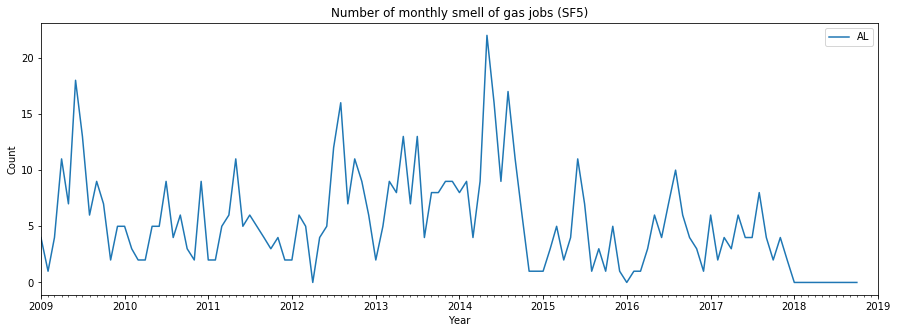

In [7]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# make the data
pivot = pd.pivot_table(df, values=['AL','BS','BU','GE','KA','MA','NM','SM'], index='date', aggfunc='sum')
pivot = pivot.reset_index()
pivot['date']=pd.to_datetime(pivot['date'])

# plot the data
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(pivot.date, pivot.AL)
#ax.plot(pivot.date, pivot.BS)
#ax.plot(pivot.date, pivot.BU)
#ax.plot(pivot.date, pivot.GE)
#ax.plot(pivot.date, pivot.KA)
#ax.plot(pivot.date, pivot.MA)
#ax.plot(pivot.date, pivot.NM)
#ax.plot(pivot.date, pivot.SM)

# format the ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(pivot.date.min().year, 1, 1)
datemax = datetime.date(pivot.date.max().year + 1, 1, 1)

ax.set_xlim(datemin, datemax)

plt.title('Number of monthly smell of gas jobs (SF5)')
plt.ylabel('Count')
plt.xlabel('Year')
plt.legend(loc="upper right")

<a id='normalise'></a>
### Normalise Data

Here are going to normalise all the features and transform the data into a supervised learning problem. The features to be predicted are removed, as we would like to predict just the *Smell of Gas Calls (SF5)* (last element in every feature array).

This step involves framing the dataset as a **supervised learning problem**. As we would like to predict the "job_type", we will set the corresponding column to be the output (label $y$).

We would like to predict the number of SF5 jobs ( $y_t$) at the current time ($t$) given the measurements at the prior time steps (lets say $t-1, t-2, \dots t-n$, in which $n$ is the number of past observations to be used to forcast $y_t$).

The function **create_window** (see _utils.py_) converts the time-series to a supervised learning problem. The new dataset is constructed as a **DataFrame**, with each column suitably named both by variable number and time step, for example, $var1(t-1)$ for **%Iron Feed** at the previous observation ($t-1$). This allows the design of a variety of different time step sequence type forecasting problems from a given univariate or multivariate time series.

In [8]:
# Set network for analysis
network = 'AL'

pivot_jobcount = pivot_jobcount.loc[pivot_jobcount['network'] == network]
pivot_weather = pivot_weather.loc[pivot_weather['network'] == network]

dataset = pd.merge(pivot_weather, pivot_jobcount, left_on=['date','network'], 
                       right_on=['date','network'], how='left')

# move count to last column as prediction variable
dataset['count'] = dataset['job_type']

# copy dates for backfilling into output
dates = pd.DataFrame()
dates['date'] = dataset['date']
dates = dates[:-12]
dates.reset_index()

# Drop string columns
#dataset = dataset.drop(['date', 'network', 'job_type'], axis=1)
dataset = dataset.drop(['network', 'job_type'], axis=1)
dataset = dataset.set_index('date')
dataset = dataset[:-12] # drop last year worth of data for testing of predictions
dataset.to_csv('../data/weather_predictions.csv')

dataset

,max_temp,min_temp,count
date,,,
2009-01-01,26.925000,11.862500,4
2009-02-01,15.850000,11.500000,1
2009-03-01,24.712500,13.312500,4
2009-04-01,26.436364,13.613636,11
2009-05-01,21.604762,9.590476,7
2009-06-01,22.053704,10.390741,18
2009-07-01,21.806410,9.294872,13
2009-08-01,19.450000,11.158333,6
2009-09-01,21.037037,9.762963,9


In [9]:
print (dataset.shape[1])

3


In [10]:
# Scikit learn libraries
from sklearn.preprocessing import MinMaxScaler #Allows normalisation

# Convert the data to float
values = dataset.values.astype('float32')

# Normalise features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Specify the number of lag
n_in = 5
n_features = dataset.shape[1]

# Transform the time-series to a supervised learning problem representation
reframed = create_window(scaled, n_in = n_in, n_out = 1, drop_nan = True)

# Summarise the new frames (reframes) 
#print(reframed.head(1))

<a id='models'></a>
## Build the Models

### Split Data into Train and Test Sets
Firstly we need to split the available data into training and test data sets.

### Define Models
Now, we are going to build the following sequential models:
 
 - [Gated Recurrent Unit (GRU)](#gru)
 - [Long Short-Term Memory (LSTM)](#lstm)
 
The models consists in a **many_to_one** architecture, in which the input is a **sequence** of the past observations and the output is the predicted value (in this case with dimension equal 1).

To build the models, we have used the following components from Keras:

 - [Sequential](https://keras.io/models/sequential/): allows us to create models layer-by-layer. 
 - [GRU](https://keras.io/layers/recurrent/): provides a GRU architecture
 - [Dense](https://keras.io/layers/core/): provides a regular fully-connected layer
 - [Activation](https://keras.io/activations/): defines the activation function to be used
 

### Train Models
Once defined the model, we need to train it by using the function [fit](https://keras.io/models/model/). This function performs the optmisation step. Hence, we can define the following parameters such as:

 - batch size: defines the number of samples that will be propagated through the network
 - epochs: defines the number of times in which all the training set (x_train_scaled) are used once to update the weights
 - validation split: defines the percentage of training data to be used for validation
 - among others (click [here](https://keras.io/models/model/) for more information)
 

### Analyse Model Performance
This function return the _history_ of the training, that can be used for further performance analysis.

Here we can see if the model overfits or underfits. First, we are going to plot the 'loss' and the 'Accuracy' in from the training step.

Once the model was trained, we can use the function [predict](https://keras.io/models/model/) for  prediction tasks. We are going to use the function **inverse_transform** (see _utils.py_) to invert the scaling (transform the values to the original ones).

Given the predictions and expected values in their original scale, we can then compute the error score for the model.

### Use Model for Predictions


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU

from sklearn.metrics import mean_squared_error # allows compute the mean square error to performance analysis

<a id='split'></a>
### Split Data into Train and Test Sets

In [12]:
# split into train and test sets
values = reframed.values

# We will use 80% of the data for training and 20% for testing
n_train = round(0.8 * values.shape[0])
train = values[:n_train, :]
test = values[n_train:, :]

# Determine dates for x axis for plotting later
output_x = dates['date'].values
output_months = output_x[n_train+n_in:]

# Split into input and outputs
n_obs = n_in * n_features
x_train = train[:, :n_obs]
y_train = train[:, n_features-1]
x_test = test[:, :n_obs]
y_test = test[:, n_features-1]

print('Number of total features (n_obs): ', x_train.shape[1])
print('Number of samples in training set: ', x_train.shape[0])
print('Number of samples in testing set: ', x_test.shape[0])

# Reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], n_in, n_features))
x_test = x_test.reshape((x_test.shape[0], n_in, n_features))

Number of total features (n_obs):  15
Number of samples in training set:  71
Number of samples in testing set:  18


<a id='gru'></a>
### Gated Recurrent Unit (GRU) Machine Learning Model

In [13]:
# Define the model.
model_gru = Sequential()

# the input_shape is the number of past observations (n_in) and the number of features 
# per past observations
model_gru.add(GRU(input_shape=(x_train.shape[1], x_train.shape[2]), 
                        units = 128, 
                        return_sequences = False))

model_gru.add(Dense(units=1)) 

# We compile the model by defining the mean absolute error (denoted by mae) as loss function and
# adam as optimizer
model_gru.compile(loss = "mae", 
                  optimizer = "adam")

#model_gru.summary()

In [14]:
# Train the model
hist_gru = model_gru.fit(x_train, y_train, 
                        epochs=1000, 
                        batch_size=256, 
                        validation_split = 0.1,
                        verbose=0, # To not print the output, set verbose=0
                        shuffle=False) 

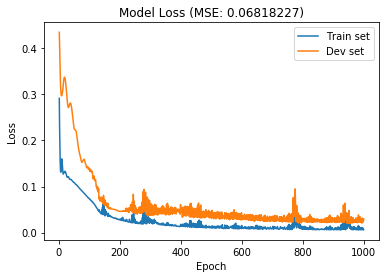

In [15]:
# Analyse model performance
yhat_gru = model_gru.predict(x_test)

# perform inverse transform on x_test and yhat_gru
rtest_X = x_test.reshape((x_test.shape[0], n_in*n_features))

# invert scaling for forecast
inv_yhat_gru = np.concatenate((rtest_X[:, (n_in-1)*n_features:-1], yhat_gru), axis=1)
inv_yhat_gru = scaler.inverse_transform(inv_yhat_gru)
inv_yhat_gru = inv_yhat_gru[:,n_features-1]

# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_gru = np.concatenate((rtest_X[:, (n_in-1)*n_features:-1], y_test), axis=1)
inv_y_gru = scaler.inverse_transform(inv_y_gru)
inv_y_gru = inv_y_gru[:,n_features-1]
    
# calculate RMSE
mse_gru = mean_squared_error(inv_y_gru, inv_yhat_gru)

# Plot fitting history
history = hist_gru.history

# Loss
plt.plot(range(1,len(history['loss'])+1),history['loss'])
plt.plot(range(1,len(history['val_loss'])+1),history['val_loss'])
plt.title('Model Loss (MSE: ' + str(mse_gru) + ')')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Dev set'], loc='best')

plt.show()

<a id='lstm'></a>
### Long-Short Term Memory (LSTM) Machine Learning Model

In [16]:
# Define the model.
model_lstm = Sequential()

# Stacking just one LSTM
model_lstm.add(LSTM(input_shape=(x_train.shape[1], x_train.shape[2]), 
                        units = 128, 
                        return_sequences = False))

# Fully connected layer
model_lstm.add(Dense(units=1)) 

model_lstm.compile(loss = "mae", 
                  optimizer = "adam")

#model_lstm.summary()

In [17]:
# Train the model
hist_lstm = model_lstm.fit(x_train, y_train, 
                           epochs=1000, 
                           batch_size=256, 
                           validation_split = 0.1,
                           verbose=0, 
                           shuffle=False
                          )

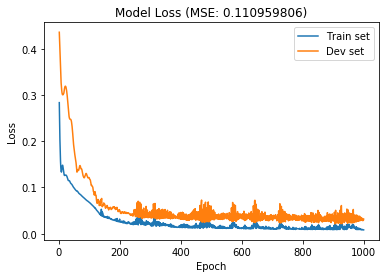

In [18]:
# Analyse model performance
yhat_lstm = model_lstm.predict(x_test)

# performing the inverse transform on x_test and yhat_lstm
rtest_X = x_test.reshape((x_test.shape[0], n_in*n_features))

# invert scaling for forecast
inv_yhat_lstm = np.concatenate((rtest_X[:, (n_in-1)*n_features:-1], yhat_lstm), axis=1)
inv_yhat_lstm = scaler.inverse_transform(inv_yhat_lstm)
inv_yhat_lstm = inv_yhat_lstm[:,n_features-1]

# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_lstm = np.concatenate((rtest_X[:, (n_in-1)*n_features:-1], y_test), axis=1)
inv_y_lstm = scaler.inverse_transform(inv_y_lstm)
inv_y_lstm = inv_y_lstm[:,n_features-1]

# calculate RMSE
mse_lstm = mean_squared_error(inv_y_lstm, inv_yhat_lstm)

# Plot fitting history
history = hist_lstm.history

# Loss
plt.plot(range(1,len(history['loss'])+1),history['loss'])
plt.plot(range(1,len(history['val_loss'])+1),history['val_loss'])
plt.title('Model Loss (MSE: ' + str(mse_lstm) + ')')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Dev set'], loc='best')

plt.show()

<a id='compare'></a>
## Compare Model Performance

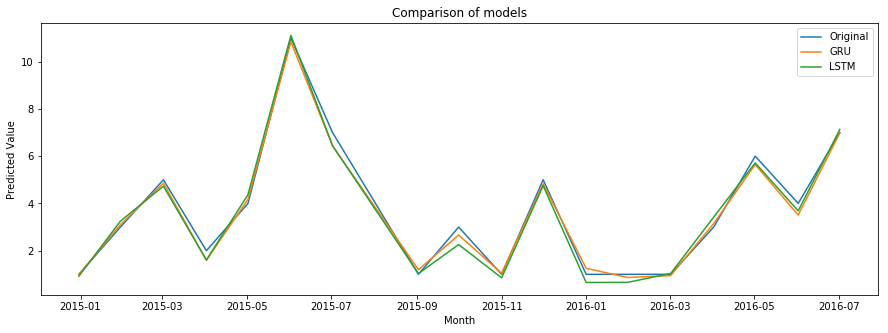

In [19]:
series = [inv_y_lstm, inv_yhat_gru, inv_yhat_lstm]
series_labels= ['Original', 'GRU', 'LSTM']

plt.figure(figsize = (15, 5))

offset = pd.Timedelta(n_in, 'M')

plt.plot(output_months-offset,inv_y_lstm, label='Original')
plt.plot(output_months-offset,inv_yhat_gru, label='GRU')
plt.plot(output_months-offset,inv_yhat_lstm, label='LSTM')

plt.xlabel("Month")
plt.ylabel("Predicted Value")
plt.title('Comparison of models')
plt.legend(loc="upper right")

In [20]:
# Save the recommended trained model
#from sklearn.externals import joblib
today = datetime.datetime.today().strftime('%Y-%m-%d')

print('______________________________________')
print('Comparing the MSE of the two models:')
print('  GRU: ', round(mse_gru*100,1), '%')
print('  LSTM: ', round(mse_lstm*100,1), '%')
print('______________________________________')

if mse_gru < mse_lstm:
    print('Use of GRU model recommended and saved.')
    saved_model = '..\outputs\GRU_model_' + network + '_' + today + '.h5'
    model_gru.save(saved_model)
    
else:
    print('Use of LSTM model recommended and saved.')
    saved_model = '..\outputs\LSTM_model_' + network + '_' + today + '.h5'
    model_lstm.save(saved_model)
print('______________________________________')

______________________________________
Comparing the MSE of the two models:
  GRU:  6.8 %
  LSTM:  11.1 %
______________________________________
Use of GRU model recommended and saved.
______________________________________


<a id='apply'></a>
## Use Model for Predictions


In [22]:
# Load pre-trained model
from keras.models import load_model
#saved_model = '..\outputs\LSTM_model_AL_2019-01-02.h5' # set manually if previously saved model required
model = load_model(saved_model)

# Load data to predict values from
predictor_data = pd.read_csv('../data/weather_predictions.csv',index_col=0, decimal=".")
predictor_data = predictor_data.reset_index()

# Determine dates for x axis for plotting later and drop from original dataframe
output_x = pd.DataFrame()
output_x = predictor_data
predictor_data = predictor_data.set_index('date')
predictor_values = predictor_data.values.astype('float32')# Convert the data to float

# Specify the number of lag (same as used for training the model)
n_in = 5
n_features = predictor_data.shape[1]
n_predict = predictor_data.shape[0]
n_obs = n_in * n_features

# Normalise features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(predictor_values)

# Transform the time-series to a supervised learning problem representation
reframed = create_window(scaled, n_in = n_in, n_out = 1, drop_nan = False)
predict = reframed.values[:n_predict, :]
x_predict = predict[:, :n_obs]

# Reshape input to be 3D [samples, timesteps, features]
x_predict = x_predict.reshape((x_predict.shape[0], n_in, n_features))

# Run model
yhat = model.predict(x_predict)

# perform the inverse transform
rpredict_X = x_predict.reshape((x_predict.shape[0], n_in*n_features))

# invert scaling (unnormalise?) for prediction
inv_yhat = np.concatenate((rpredict_X[:, (n_in-1)*n_features:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,n_features-1]
df_prediction = pd.DataFrame(inv_yhat)
df_prediction.columns=[job_type]
df_prediction = round(df_prediction[job_type])

# Add predicted data to dates
df_prediction = output_x.join(df_prediction)

# Shift predictions up by window size to align dates correctly
df_prediction[job_type] = df_prediction[job_type].shift(-n_in)
df_prediction = df_prediction[:-n_in]
df_prediction = df_prediction.set_index('date')

#######################
# TO DO: 
######################

# Save predicted data to spreadsheet
predicted_data = '../outputs/GRU_model_predictions-' + network + '-' + today + '.csv'
df_prediction.to_csv(predicted_data)

df_prediction
#predictor_data

,max_temp,min_temp,count,SF5
date,,,,
2009-01-01,26.925000,11.862500,4,4.0
2009-02-01,15.850000,11.500000,1,1.0
2009-03-01,24.712500,13.312500,4,4.0
2009-04-01,26.436364,13.613636,11,11.0
2009-05-01,21.604762,9.590476,7,7.0
2009-06-01,22.053704,10.390741,18,18.0
2009-07-01,21.806410,9.294872,13,13.0
2009-08-01,19.450000,11.158333,6,6.0
2009-09-01,21.037037,9.762963,9,9.0
